In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from statsmodels.tsa.arima.model import ARIMA
from nbeats_pytorch.model import NBeatsNet

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
TIME_STEP = 5 # 定义步长 K
INPUT_DIM = 4
output_dim = 4
batch_size = 10  # 每轮训练模型时，样本的数量
epochs = 50  # 训练60轮次
hidden_size = 64
layer_num = 4
patience = 10
chunksize = 10000

reader = pd.read_csv(
    "/data/hmn_data/alibaba_cluster_data/MSRTQps_sort.csv", chunksize=chunksize)

In [3]:
tmp_df=pd.DataFrame()

for index, chunk in enumerate(reader):
    tmp_df = pd.concat([tmp_df, chunk])

In [4]:
# 获取所有唯一的id值
unique_ids = tmp_df['msinstanceid'].unique()


In [32]:
# 从唯一的id值中随机选择三个，不放回
train_ids = np.random.choice(unique_ids, 3, replace=False)
# 从唯一的id值中随机选择两个，不放回
val_ids = np.random.choice(unique_ids, 2, replace=False)
# 从唯一的id值中随机选择一个，不放回
test_ids = np.random.choice(unique_ids, 1, replace=False)

In [33]:
def load_df(df, selected_ids):
    # 提取包含所选id的所有行
    selected_rows = []
    for selected_id in selected_ids:
        # 或者使用 df.loc[df['msinstanceid'] == selected_id]
        rows = df.query('msinstanceid == @selected_id')
        selected_rows.append(rows)

    # 将提取的行组合成一个新的DataFrame
    selected_rows_df = pd.concat(selected_rows)
    return selected_rows_df


In [34]:
train_df = load_df(tmp_df, train_ids)
val_df = load_df(tmp_df, val_ids)
test_df = load_df(tmp_df, test_ids)

In [35]:
test_df

,Unnamed: 0,msinstanceid,timestamp,HTTP_MCR,HTTP_RT
6638263,9190,6906eb8615a058f67aa451d44aebf3689e9b83139524c5...,0,10.125214,10.125214
6638264,31585,6906eb8615a058f67aa451d44aebf3689e9b83139524c5...,60000,9.946150,9.946150
6638265,54017,6906eb8615a058f67aa451d44aebf3689e9b83139524c5...,120000,9.548920,9.548920
6638266,76396,6906eb8615a058f67aa451d44aebf3689e9b83139524c5...,180000,9.617710,9.617710
6638267,98795,6906eb8615a058f67aa451d44aebf3689e9b83139524c5...,240000,9.374366,9.374366
...,...,...,...,...,...
6638979,16124326,6906eb8615a058f67aa451d44aebf3689e9b83139524c5...,42960000,12.816340,12.816340
6638980,16146600,6906eb8615a058f67aa451d44aebf3689e9b83139524c5...,43020000,12.761278,12.761278
6638981,16168809,6906eb8615a058f67aa451d44aebf3689e9b83139524c5...,43080000,13.034235,13.034235
6638982,16191069,6906eb8615a058f67aa451d44aebf3689e9b83139524c5...,43140000,12.780153,12.780153


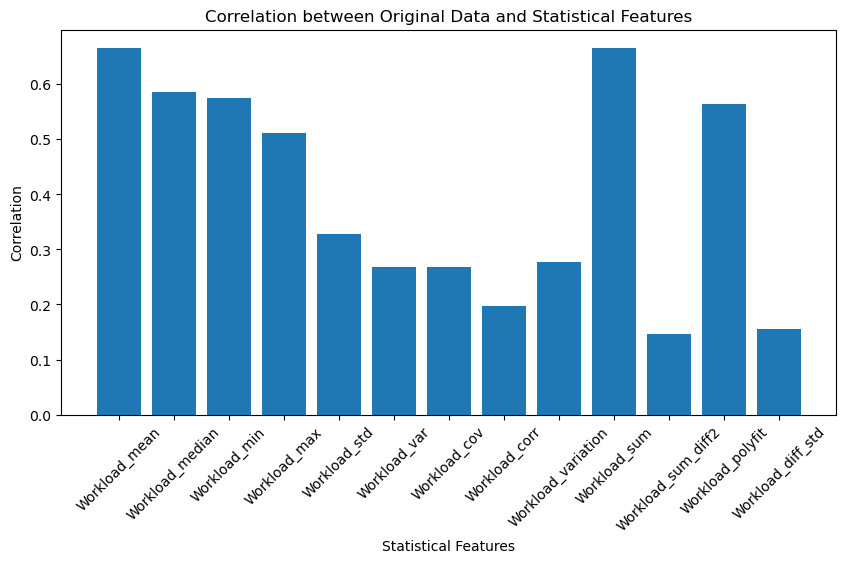

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假设您的时间序列数据存储在一个名为data的列表中
data = test_df["HTTP_RT"]  # 请用您的实际数据替换
window_size = TIME_STEP

# 将数据转换为Pandas DataFrame
data_series = pd.Series(data)
df = pd.DataFrame({'Workload': data_series})
# 使用rolling滚动窗口，窗口大小为7
roll_data = df['Workload'].rolling(window=window_size)
df["Workload_mean"] = roll_data.mean()
df["Workload_median"] = roll_data.median()
df["Workload_min"] = roll_data.min()
df["Workload_max"] = roll_data.max()
df["Workload_std"] = roll_data.std()
df["Workload_var"] = roll_data.var()
df["Workload_cov"] = df['Workload'].rolling(window=window_size).cov(df['Workload'])
df["Workload_corr"] = df['Workload'].rolling(window=window_size).corr(df['Workload'])
df["Workload_variation"] = df["Workload_std"] / df["Workload_mean"]
df["Workload_sum"] = roll_data.sum()
df["Workload_sum_diff2"] = df["Workload_sum"].shift(1) - df["Workload_sum"].shift(2)

# 计算线性拟合斜率
x = range(window_size)


def z(y): return np.polyfit(x, y, 1)[0] if len(y.dropna()) == window_size else np.nan


df["Workload_polyfit"] = roll_data.apply(z)

# 计算一阶差分的均方差
roll_data_diff = df['Workload'].diff(1).rolling(window=window_size)
df["Workload_diff_std"] = roll_data_diff.std()

# 删除有NaN值的行
df = df.dropna()

# 计算原始数据与新特征之间的皮尔逊相关性系数
correlations = df.corr().iloc[0, 1:].to_dict()

# 使用matplotlib绘制相关性图像
plt.figure(figsize=(10, 5))
plt.bar(correlations.keys(), correlations.values())
plt.xticks(rotation=45)
plt.xlabel("Statistical Features")
plt.ylabel("Correlation")
plt.title("Correlation between Original Data and Statistical Features")
plt.show()


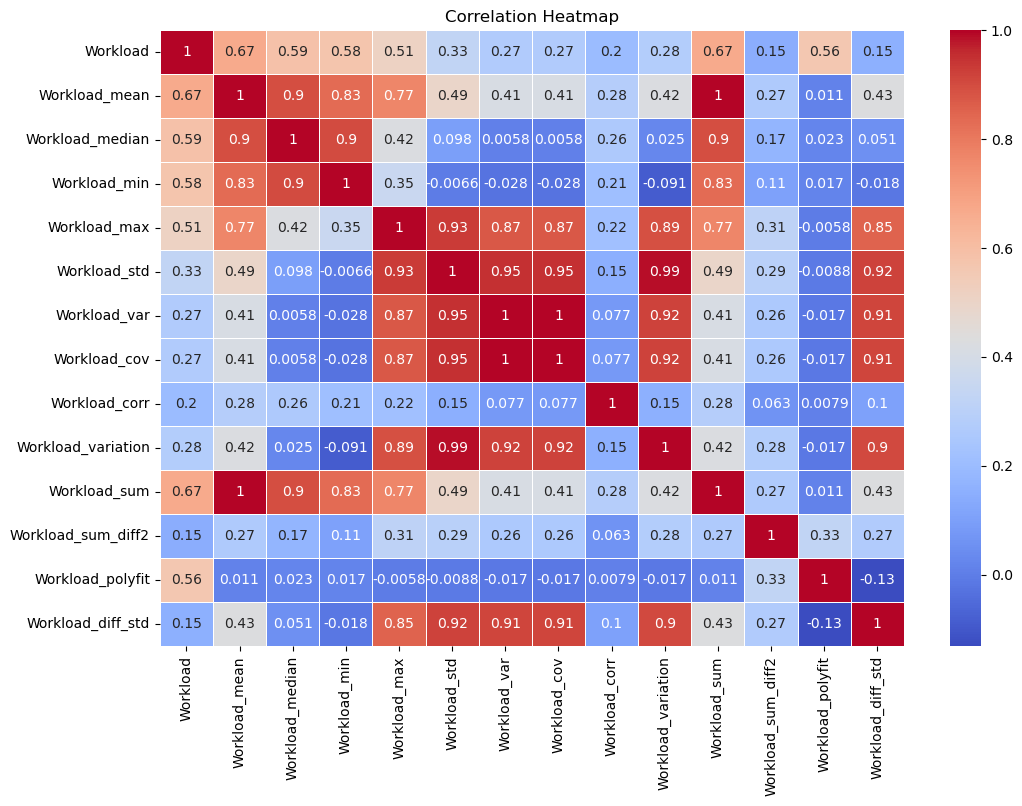

In [37]:
import seaborn as sns

# 计算相关性矩阵
corr_matrix = df.corr()

# 绘制热力图
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

In [38]:
import pywt

# 小波滤噪
def wavelet_denoising(data):
    # 小波函数取db8
    db4 = pywt.Wavelet('db8')

    # 分解
    coeffs = pywt.wavedec(data, db4)
    # 高频系数置零
    coeffs[len(coeffs) - 1] *= 0
    coeffs[len(coeffs) - 2] *= 0
    # 重构
    meta = pywt.waverec(coeffs, db4)
    meta = meta[:len(data)]
    return meta

In [39]:
df

,Workload,Workload_mean,Workload_median,Workload_min,Workload_max,Workload_std,Workload_var,Workload_cov,Workload_corr,Workload_variation,Workload_sum,Workload_sum_diff2,Workload_polyfit,Workload_diff_std
6638269,9.011790,9.365841,9.374366,9.011790,9.617710,0.239988,0.057594,0.057594,1.0,0.025624,46.829204,-0.848796,-0.141555,0.178014
6638270,9.046891,9.265435,9.276419,9.011790,9.617710,0.249089,0.062045,0.062045,1.0,0.026884,46.327176,-0.934360,-0.150421,0.153620
6638271,9.140456,9.169984,9.140456,9.011790,9.374366,0.153419,0.023537,0.023537,1.0,0.016731,45.849922,-0.502028,-0.069735,0.160678
6638272,9.230564,9.141224,9.140456,9.011790,9.276419,0.113921,0.012978,0.012978,1.0,0.012462,45.706120,-0.477254,0.003696,0.152964
6638273,8.895082,9.064957,9.046891,8.895082,9.230564,0.127609,0.016284,0.016284,1.0,0.014077,45.324783,-0.143802,-0.004974,0.207123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6638979,12.816340,13.861628,14.495171,11.484124,15.618828,1.680729,2.824851,2.824851,1.0,0.121250,69.308139,-2.482242,-0.861602,1.812133
6638980,12.761278,13.290118,12.816340,11.484124,14.893675,1.395466,1.947325,1.947325,1.0,0.105000,66.450588,-4.092118,-0.554512,1.815982
6638981,13.034235,12.997930,12.816340,11.484124,14.893675,1.222268,1.493939,1.493939,1.0,0.094036,64.989652,-2.857551,-0.244173,1.817231
6638982,12.780153,12.575226,12.780153,11.484124,13.034235,0.619665,0.383985,0.383985,1.0,0.049277,62.876130,-1.460936,0.280995,1.778239


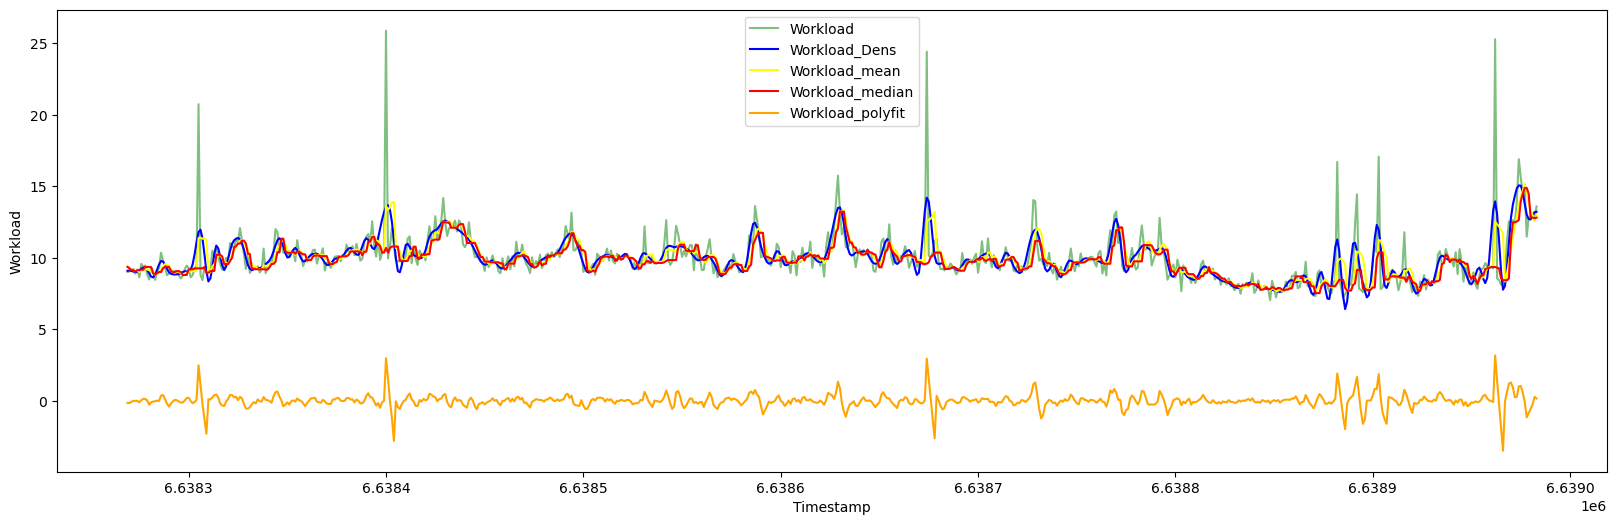

In [40]:


df["Workload_Dens"] = wavelet_denoising(df["Workload"])

plt.figure(figsize=(20, 6))
plt.plot(df["Workload"], label="Workload", color='green', alpha=0.5)
plt.plot(df["Workload_Dens"], label="Workload_Dens", color='blue')
plt.plot(df["Workload_mean"], label="Workload_mean", color='yellow')
plt.plot(df["Workload_median"], label="Workload_median", color='red')
plt.plot(df["Workload_polyfit"], label="Workload_polyfit", color='orange')

plt.xlabel("Timestamp")
plt.ylabel("Workload")
plt.legend()
plt.show()
